In [1]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

idx = pd.IndexSlice

Open cov data, set group constant based on the data

In [2]:
f = open('scale.rev08.252groupcov7.1.new.toc', 'r')

In [2]:
_COV_GROUPS = 252

Some helper functions

In [3]:
def parse_material_line(line):
    """
    Parses a line like
     Material 1= 1013027 reaction 1= 2, Material 2= 1013027 reaction 2= 2
    for mat # and rx #
    """
    parts = line.strip().split()
    #
    mat_id_1 = int(parts[2])
    rx_1 = int(parts[5].rstrip(','))
    
    mat_id_2 = int(parts[8])
    rx_2 = int(parts[11])
    
    return mat_id_1, rx_1, mat_id_2, rx_2


In [120]:
def parse_material_line_tendl(line):
    """
    Parses a line like 
     material mat-mt=(5459,  1)
     or
    1st material mat-mt=(5459,  1)  vs  2nd material mat-mt=(5459,  2)
    for mat # and rx #
    """
    parts = line.strip().split('=')
    if len(parts) == 2:
        zaid_mt = parts[-1].lstrip('(').rstrip(')')

        zaid_mt = zaid_mt.split(',')
        mat_id_1 = int(zaid_mt[0])
        rx_1 = int(zaid_mt[1])

        mat_id_2 = mat_id_1
        rx_2 = rx_1
    elif len(parts) == 3:
        zaid_mt = parts[1].lstrip('(').rstrip('  vs  2nd material mat-mt').rstrip(')')
        zaid_mt = zaid_mt.split(',')
        mat_id_1 = int(zaid_mt[0])
        rx_1 = int(zaid_mt[1])
        
        zaid_mt = parts[2].lstrip('(').rstrip(')')
        zaid_mt = zaid_mt.split(',')
        mat_id_2 = int(zaid_mt[0])
        rx_2 = int(zaid_mt[1])
    else:
        raise Exception('Got unknown format material line {0}'.format(line))
    
    return mat_id_1, rx_1, mat_id_2, rx_2

def fixed_split(line, length=5):
    'chunks a line up into length pieces'
    split_line = []
    _l = ''
    for c in line:
        _l += c
        if len(_l) == length:
            if _l == '*****':
                _l = 0
            split_line.append(int(_l))
            _l = ''
    return split_line
        
        
def read_corr_mat_tendl(f, COV_GROUPS):
    """
    Reads lines in f generating a corr matrix by parsing the found corr lines
    
    Parameters
    ----------
    COV_GROUPS : int
        The longest cov group in the file
    """
    
    _COV_GROUPS = COV_GROUPS
    df = pd.DataFrame(index=range(1, 1+_COV_GROUPS), columns=range(1, 1+_COV_GROUPS))
    
    force_row_in_line = False
    for line in f:
        if force_row_in_line:
            line = l_full
            
        if ('row' in line and 'material' not in line) or force_row_in_line:
            # skip this line that only contains column
            header = [int(i) for i in line.split()[1:]]
            # skip the next line that is column-------------
            if not force_row_in_line:
                # if we accidently read the row line, we don't need this readline
                f.readline()
                
            # reset the row reader since it should not be true more than once in a row
            force_row_in_line = False
            
            # if less than 25 groups present in correlation matrix, only read that many (check that row[0] = 1)
            if len(header) < 25 and header[0] == 1:
                _COV_GROUPS = len(header)
                df = pd.DataFrame(index=range(1, 1+_COV_GROUPS), columns=range(1, 1+_COV_GROUPS))
                cov_lines = [f.readline().rstrip('\n')[6:] for i in range(_COV_GROUPS)]
                
            else:
                # now there can still be a chance we have more than 25 but less than the given _COV_GROUPS
                # this requires a readahead..

                # tendl often gives the same group structure but the cov size changes
                cov_lines = []
                for i in range(_COV_GROUPS):
                    l_full = f.readline()
                    l = l_full.rstrip('\n')[6:]
                    # this breaks at a row
                    if 'row' in l_full:
                        # got to row while in _COV_GROUPS read loop
                        if len(cov_lines) != df.shape[0]:
                            # remake the df, change _COV_GROUPS
                            _COV_GROUPS = len(cov_lines)
                            df = pd.DataFrame(index=range(1, 1+_COV_GROUPS), columns=range(1, 1+_COV_GROUPS))
                        force_row_in_line = True
                        break
                    cov_lines.append(l)
            try:
                data = [fixed_split(c, length=5) for c in cov_lines]
            except:
                print(cov_lines)
                blah
            
            _temp_df = pd.DataFrame(data)

            df.loc[:, header] = _temp_df.values
            
        if header[-1] == _COV_GROUPS or len(header) < 25:
            force_row_in_line = False
            _COV_GROUPS = COV_GROUPS
            break


    return df
        
    

In [5]:
def read_corr_mat(f):
    """
    Reads lines in f generating a corr matrix by parsing the found corr lines
    """
    
    df = pd.DataFrame(index=range(1, 1+_COV_GROUPS), columns=range(1, 1+_COV_GROUPS))
    
    for line in f:
        if 'column' in line:
            # skip this line that only contains column
            header = [int(i) for i in f.readline().split()]
            # skip the next line that is ---- ---- (seperators)
            f.readline()
            # read all the cov group for this chunk of data
            
            cov_lines = [f.readline() for i in range(_COV_GROUPS)]
            str_line = StringIO(' '.join(cov_lines))
            _temp_df = pd.read_csv(str_line, delim_whitespace=True, header=None)
            df.loc[:, header] = _temp_df.iloc[:, 1:].values
            
        if header[-1] == _COV_GROUPS:
            break

    return df

Header for std dev tables

In [6]:
std_dev_header = ['groups', 'e low', 'e high', 'x-sec(1)', 'x-sec(2)', 'rel.s.d.(1)',  'rel.s.d(2)', 's.d.(1)', 's.d(2)']

Setup hdf5 table to store data in

In [63]:
print('uncomment to clear the cov hdf')
#h = pd.HDFStore('scale_cov_252.h5', 'w')


uncomment to clear the cov hdf


Optionally turn off warnings so we can label variables as #'s which are not python variable names

In [8]:
import warnings
warnings.filterwarnings('ignore')

Parse the tables

In [31]:
prog_bar = FloatProgress(min=0, max=4563 - 1) # number of cov matrix in scale data - 1
display(prog_bar)

for line in f:
    # this outer loop keeps things going until the EOF
    if 'Material' in line:
        mat_id_1, rx_1, mat_id_2, rx_2 = parse_material_line(line)

        # read forward # groups lines
        cov_lines = [f.readline() for i in range(_COV_GROUPS + 1)] # first line is header, include it when reading
        str_line = StringIO(' '.join(cov_lines[1:])) # remove the first line which is header
        std_dev_df = pd.read_csv(str_line, delim_whitespace=True, header=None)
        std_dev_df.columns = std_dev_header
        std_dev_df.set_index('groups', inplace=True)
    
        f.readline() #   *** correlation matrix ***
        f.readline() #  column=material 1     row=material 2
        corr_mat_df = read_corr_mat(f)
        h.put('{0}/{1}/{2}/{3}/std_dev'.format(mat_id_1, rx_1, mat_id_2, rx_2), std_dev_df)
        h.put('{0}/{1}/{2}/{3}/corr'.format(mat_id_1, rx_1, mat_id_2, rx_2), corr_mat_df)
        prog_bar.value += 1


ValueError: I/O operation on closed file.

In [10]:
h.close()
f.close()

# Another hack to parse TENDL cov 

In [122]:
h = pd.HDFStore('scale_cov_252.h5', 'a')

In [123]:
_COV_GROUPS = 187
std_dev_header = ['groups', 'e low', 'e high', 'x-sec(1)', 'x-sec(2)', 'rel.s.d.(1)',  'rel.s.d(2)', 's.d.(1)', 's.d(2)']
with open('./xe135m/Xe135m-njoy-cov-187g.all.300.K.matrix.txt') as f:
    for line in f:
        # this outer loop keeps things going until the EOF
        if 'material' in line:
            mat_id_1, rx_1, mat_id_2, rx_2 = parse_material_line_tendl(line)

            # read forward # groups lines
            cov_lines = [f.readline() for i in range(_COV_GROUPS + 1)] # first line is header, include it when reading
            str_line = StringIO(' '.join(cov_lines[1:])) # remove the first line which is header
            std_dev_df = pd.read_csv(str_line, delim_whitespace=True, header=None)

            # make the TENDL cov xsec look like the SCALE ones
            if std_dev_df.shape[1] == 5:
                std_dev_df.columns = ['groups', 'e high', 'x-sec(1)', 'rel.s.d.(1)', 's.d.(1)']
                std_dev_df['e low'] = std_dev_df['e high']
                std_dev_df.loc[idx[0:_COV_GROUPS-2], 'e low'] = std_dev_df.loc[idx[1:_COV_GROUPS-1], 'e low'].values
                std_dev_df.loc[_COV_GROUPS-1, 'e low'] = 0
                std_dev_df.loc[:, 'x-sec(2)'] = std_dev_df.loc[:, 'x-sec(1)']
                std_dev_df.loc[:, 's.d(2)'] = std_dev_df.loc[:, 's.d.(1)']
                std_dev_df.loc[:, 'rel.s.d(2)'] = std_dev_df.loc[:, 'rel.s.d.(1)']
            elif std_dev_df.shape[1] == 6:
                std_dev_df.columns = ['groups', 'e high', 'x-sec(1)', 'x-sec(2)', 'rel.s.d.(1)', 'rel.s.d(2)']
                std_dev_df['e low'] = std_dev_df['e high']
                std_dev_df.loc[idx[0:_COV_GROUPS-2], 'e low'] = std_dev_df.loc[idx[1:_COV_GROUPS-1], 'e low'].values
                std_dev_df.loc[_COV_GROUPS-1, 'e low'] = 0
                std_dev_df.loc[:, 's.d.(1)'] = std_dev_df.loc[:, 'x-sec(1)'].values * std_dev_df.loc[:, 'rel.s.d.(1)'].values
                std_dev_df.loc[:, 's.d(2)'] = std_dev_df.loc[:, 'x-sec(2)'].values * std_dev_df.loc[:, 'rel.s.d(2)'].values
            else:
                raise Exception('got different than 5 or 6 columns in xsec')

            std_dev_df = std_dev_df.reindex(columns=std_dev_header)
            
            std_dev_df.set_index('groups', inplace=True)

            f.readline() #   *** correlation matrix ***
            f.readline() #    column material mat-mt=(5459, 28)  vs  row material mat-mt=(5459, 28)

            corr_mat_df = read_corr_mat_tendl(f, _COV_GROUPS)
            print('{0}/{1}/{2}/{3}/std_dev'.format(mat_id_1, rx_1, mat_id_2, rx_2))
            h.put('{0}/{1}/{2}/{3}/std_dev'.format(mat_id_1, rx_1, mat_id_2, rx_2), std_dev_df)
            h.put('{0}/{1}/{2}/{3}/corr'.format(mat_id_1, rx_1, mat_id_2, rx_2), corr_mat_df)

h.close()

5459/1/5459/1/std_dev
5459/1/5459/2/std_dev
5459/1/5459/3/std_dev
5459/1/5459/4/std_dev
5459/1/5459/16/std_dev
5459/1/5459/51/std_dev
5459/1/5459/91/std_dev
5459/1/5459/102/std_dev
5459/1/5459/103/std_dev
5459/1/5459/107/std_dev
5459/2/5459/2/std_dev
5459/2/5459/3/std_dev
5459/2/5459/4/std_dev
5459/2/5459/16/std_dev
5459/2/5459/51/std_dev
5459/2/5459/91/std_dev
5459/2/5459/102/std_dev
5459/2/5459/103/std_dev
5459/2/5459/107/std_dev
5459/3/5459/3/std_dev
5459/3/5459/4/std_dev
5459/3/5459/16/std_dev
5459/3/5459/51/std_dev
5459/3/5459/91/std_dev
5459/3/5459/102/std_dev
5459/3/5459/103/std_dev
5459/3/5459/107/std_dev
5459/4/5459/4/std_dev
5459/16/5459/16/std_dev
5459/17/5459/17/std_dev
5459/22/5459/22/std_dev
5459/24/5459/24/std_dev
5459/28/5459/28/std_dev
5459/32/5459/32/std_dev
5459/33/5459/33/std_dev
5459/41/5459/41/std_dev
5459/51/5459/51/std_dev
5459/51/5459/91/std_dev
5459/51/5459/102/std_dev
5459/51/5459/103/std_dev
5459/51/5459/107/std_dev
5459/53/5459/53/std_dev
5459/54/5459/54/st

In [124]:
h = pd.HDFStore('scale_cov_252.h5', 'a')

In [125]:
d = h['5459/102/5459/102/corr']

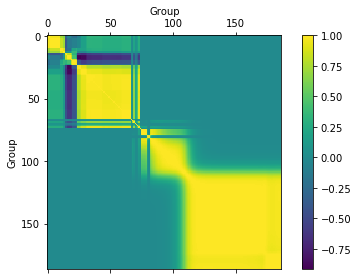

In [146]:
fig, ax = plt.subplots()
c = ax.matshow(d.values/1000)
plt.colorbar(c)
ax.set_xlabel('Group')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Group')
plt.tight_layout()
plt.savefig('xe135m_mt=102_corr.eps')

In [134]:
h.close()